In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
import torchvision.models as models
#from pl_bolts.callbacks import ORTCallback
import torchmetrics


print('CUDA available:', torch.cuda.is_available())

CUDA available: True


# ⬇️ Data

In [2]:
ROOT_DIR = '/tcmldrive/databases/Public/TCGA/data/'
TRAIN_DIR = ROOT_DIR + 'train'
TEST_DIR = ROOT_DIR + 'test'

class params:
    num_workers = 24
    bs = 256

### Transforms
# rgb_mean = (0.4914, 0.4822, 0.4465)
# rgb_std = (0.2023, 0.1994, 0.2010)
train_tfms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(rgb_mean, rgb_std),
])
test_tfms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(rgb_mean, rgb_std),
])

### Datasets
train_ds = torchvision.datasets.ImageFolder(TRAIN_DIR, train_tfms)
test_ds = torchvision.datasets.ImageFolder(TEST_DIR, test_tfms)

### Dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=False)

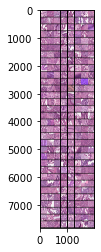

In [3]:
images = next(iter(train_dl))[0]
plt.imshow(torchvision.utils.make_grid(images, padding=20).permute(1, 2, 0))

# Model

In [4]:
class VisionModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.criteria = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        loss = self.criteria(logits, y)
        acc = torchmetrics.functional.accuracy(logits.softmax(dim=-1), y)
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        loss = loss.unsqueeze(dim=-1)
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        val_loss = self.criteria(logits, y)
        val_acc = torchmetrics.functional.accuracy(logits.softmax(dim=-1), y)
        
        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)
        val_loss = val_loss.unsqueeze(dim=-1)
        return {"val_loss": val_loss, "val_acc": val_acc}
    # def train_dataloader():
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
model = VisionModel()
trainer = Trainer(gpus=1, max_epochs=30)
#IN TRAINER: , callbacks=ORTCallback()
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=test_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/shats/miniconda3/envs/firstenv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:732: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | model    | ResNet           | 11.7 M
1 | criteria | CrossEntropyLoss | 0     
----------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
!jupyter notebook stop 8888